In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
print(f"Training data shape: {train_data.shape}") 
print(f"Test data shape: {test_data.shape}")

Training data shape: (891, 12)
Test data shape: (418, 11)


In [20]:
print(f"Missing values in data training data:")
print(train_data.isnull().sum())

Missing values in data training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [21]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


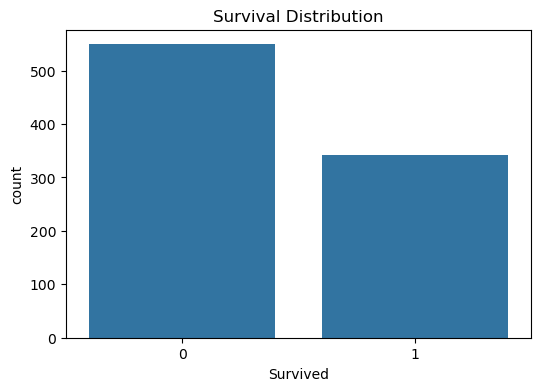

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train_data)
plt.title('Survival Distribution')
plt.show()
# 0 = No, 1 = Yes

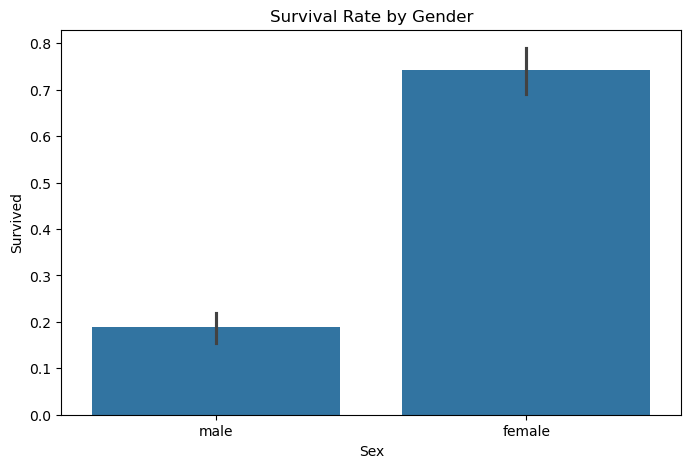

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Survival Rate by Gender')
plt.show()

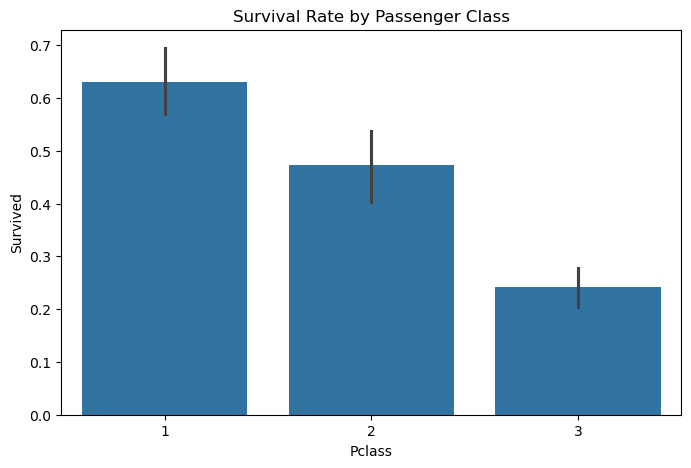

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Passenger Class')
plt.show()
# 1 = 1st class/upper class, 2 = 2nd class/middle class, 3 = 3rd class/lower class

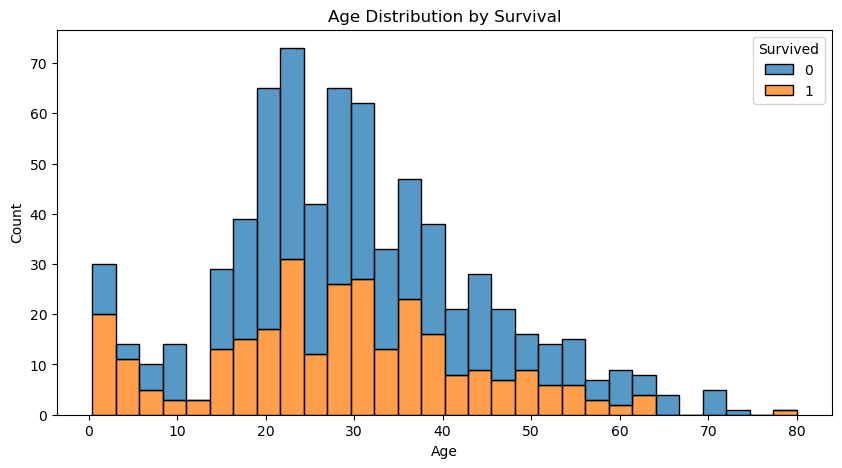

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Age Distribution by Survival')
plt.show()

In [29]:
def feature_engineering(df):
    # Copy of the dataframe
    data = df.copy()
    
    # Extract titles from names
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Group rare titles
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    data.loc[data['Title'].isin(rare_titles), 'Title'] = 'Rare'
    data.loc[data['Title'] == 'Mlle', 'Title'] = 'Miss'
    data.loc[data['Title'] == 'Ms', 'Title'] = 'Miss'
    data.loc[data['Title'] == 'Mme', 'Title'] = 'Mrs'
    
    # Family size feature
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    # isAlone feature
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    # Extract deck from cabin
    data['Deck'] = data['Cabin'].str.slice(0, 1)
    
    return data

In [30]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [32]:
train_data[['Title', 'FamilySize', 'IsAlone', 'Deck']].head()

,Title,FamilySize,IsAlone,Deck
0,Mr,2,0,NaN
1,Mrs,2,0,C
2,Miss,1,1,NaN
3,Mrs,2,0,C
4,Mr,1,1,NaN


In [34]:
X = train_data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
y = train_data['Survived']

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [36]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'Deck']

In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [38]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [44]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title', 'IsAlone',
                                                   'Deck'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [45]:
y_pred = model.predict(X_val)

In [46]:
print("Model Accuracy:", accuracy_score(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Model Accuracy: 0.8212290502793296

Confusion Matrix:
[[89 16]
 [16 58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       105
           1       0.78      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



In [47]:
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'cat':
        # feature names from the OneHotEncoder
        feature_names.extend(
            preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(features)
        )
    else:
        feature_names.extend(features)

In [48]:
coefficients = model.named_steps['classifier'].coef_[0]

In [49]:
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

In [50]:
coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('AbsCoef', ascending=False).drop('AbsCoef', axis=1)

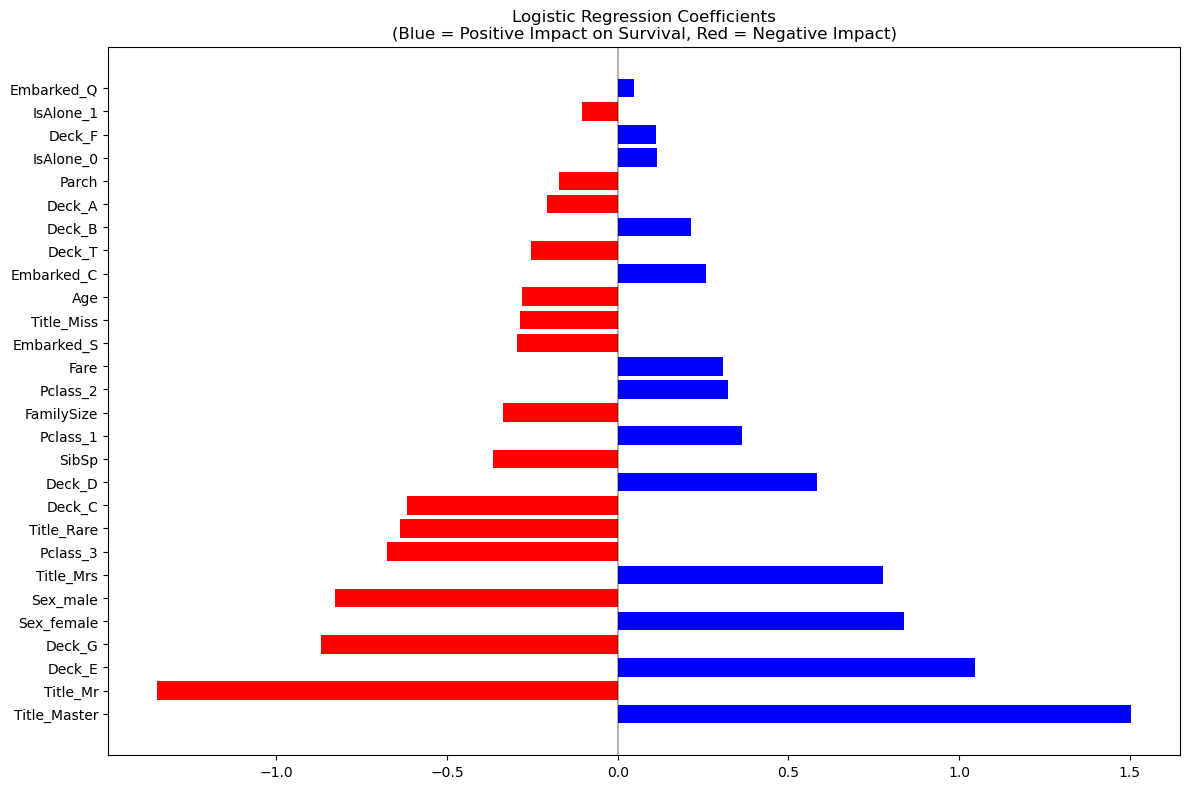

In [51]:
plt.figure(figsize=(12, 8))
coef_df['Color'] = coef_df['Coefficient'].apply(lambda x: 'blue' if x > 0 else 'red')
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=coef_df['Color'])
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Logistic Regression Coefficients\n(Blue = Positive Impact on Survival, Red = Negative Impact)')
plt.tight_layout()
plt.show()

In [52]:
X_test = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [53]:
test_predictions = model.predict(X_test)

In [54]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

In [55]:
submission.to_csv('titanic_submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
